<a href="https://colab.research.google.com/github/danielbauer1979/ML_656/blob/main/SLC_AlgFairness_inclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 9: Algorithmic Bias and Fairness

Dani Bauer (w/ Jim Guszcza), 11/2023

In this tutorial, we discuss approaches how to analyze a predictive algorithm with regards to "fairness." We do so in the context of a well-known case study on an algorithm that assists judges in parole decisions. We go over different notions of fairness, discuss tradeoffs, and explain the intuition behind the results of the analyses. We also discuss approaches how to adjust algorithms to enforce fairness. A second case study, which we will ask you to work on, illustrates how these ideas apply in the actuarial context.

### Load required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc

In [ ]:
!pip install aequitas
#Another library that seems to be popular is fariness 360:
#!pip install aif360

In [3]:
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

# Compas Case Study

The Compas data originates from a [well-known case study on algorithmic bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing). The background is [as follows](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm): Across the nation, judges, probation and parole officers are increasingly using algorithms to assess a criminal defendant's likelihood of becoming a recidivist---a term used to describe criminals who re-offend. One of the commercial tools made by Northpointe, Inc. is called COMPAS (which stands for Correctional Offender Management Profiling for Alternative Sanctions). The case study compares outcomes and risk scores for individuals belonging to different races. In what follows, we will go through some of these analyses ourselves.

## The Compas Data

The data is in our github folder. Let's take a look:

In [4]:
!git clone https://github.com/danielbauer1979/ML_656.git

Cloning into 'ML_656'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (208/208), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 325 (delta 118), reused 123 (delta 76), pack-reused 117
Receiving objects: 100% (325/325), 26.62 MiB | 6.19 MiB/s, done.
Resolving deltas: 100% (168/168), done.
Updating files: 100% (49/49), done.


In [5]:
dat = pd.read_csv('ML_656/compasdata.csv')
dat.head()

,Unnamed: 0,Two_yr_Recidivism,Number_of_Priors,Age_Above_FourtyFive,Age_Below_TwentyFive,Female,Misdemeanor,ethnicity,probability,predicted
0,4,no,-0.684358,no,no,Male,yes,Other,0.315156,0
1,5,yes,2.266882,no,no,Male,no,Caucasian,0.885462,1
2,7,no,-0.684358,no,no,Female,yes,Caucasian,0.255268,0
3,11,no,-0.684358,no,no,Male,no,African_American,0.417391,0
4,14,no,-0.684358,no,no,Male,yes,Hispanic,0.320098,0


In [6]:
dat.describe()

,Unnamed: 0,Number_of_Priors,probability,predicted
count,6172.000000,6.172000e+03,6172.000000,6172.000000
mean,3086.500000,-2.475157e-17,0.493372,0.452690
std,1781.847262,1.000000e+00,0.186090,0.497797
min,1.000000,-6.843578e-01,0.123114,0.000000
25%,1543.750000,-6.843578e-01,0.351470,0.000000
50%,3086.500000,-4.735549e-01,0.473372,0.000000
75%,4629.250000,1.588535e-01,0.613742,1.000000
max,6172.000000,7.326149e+00,0.996072,1.000000


The data contains information on recidivism of 6,172 individuals as well as information on the individual's age, sex, criminal history, their ethnicity---and the risk score they received from the COMPAS algorithm.

To simplify the situation, we focus on two ethnicity levels only: African-Americans and Caucasians.

In [7]:
dat = dat.loc[(dat['ethnicity'] == 'Caucasian') | (dat['ethnicity'] == 'African_American')]
dat.describe()

,Unnamed: 0,Number_of_Priors,probability,predicted
count,5278.000000,5278.000000,5278.000000,5278.000000
mean,3093.678856,0.045344,0.508440,0.483327
std,1773.109554,1.027854,0.185615,0.499769
min,2.000000,-0.684358,0.136889,0.000000
25%,1570.250000,-0.684358,0.367219,0.000000
50%,3097.500000,-0.262752,0.493538,0.000000
75%,4614.750000,0.369656,0.625158,1.000000
max,6171.000000,7.326149,0.996072,1.000000


So we still have the majority of individuals included. We will consider the African-Americans as the "protected" class.

We commence by exploring the data some and looking at fairness manually, but then we will also explore how to use the Aequitas package in this setting.

### Fairness scores vs. recidivism rates

Let's start by comparing the COMPAS scores between the two ethic groups (see also the density plots from the fairness package above):

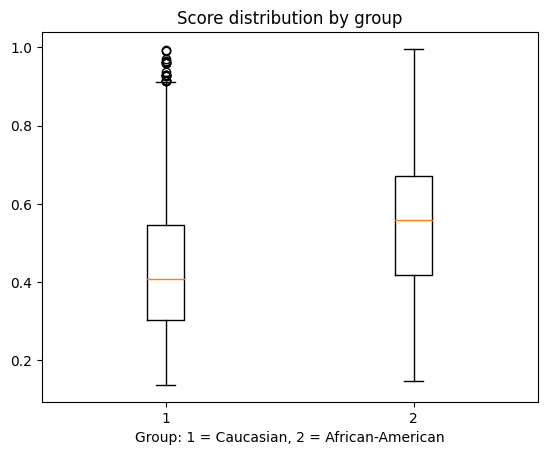

In [8]:
plt.title("Score distribution by group")
plt.xlabel("Group: 1 = Caucasian, 2 = African-American")
plt.boxplot([dat.loc[dat['ethnicity'] == 'Caucasian']['probability'],dat.loc[dat['ethnicity'] == 'African_American']['probability']])
plt.show()

The distribution of scores in the African-American group has a higher median and higher percentiles than the scores in the Caucasian group.

However, consider the number of re-offenders between the group, we see the following:

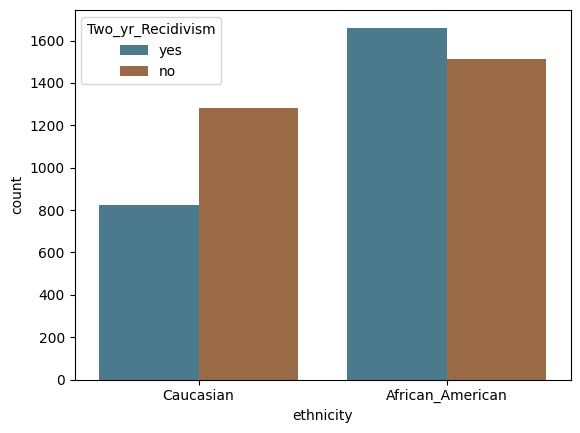

In [9]:
aq_palette = sns.diverging_palette(225, 35, n=2)
by_race = sns.countplot(x="ethnicity", hue="Two_yr_Recidivism", data=dat[dat.ethnicity.isin(['African_American', 'Caucasian'])], palette=aq_palette)

Let's consider raw averages of re-offenders in the two groups -- for caucasians:

In [10]:
np.average(dat.loc[dat['ethnicity'] == 'Caucasian']['Two_yr_Recidivism'] == 'yes')

0.3908701854493581

And for the protected group:

In [11]:
np.average(dat.loc[dat['ethnicity'] == 'African_American']['Two_yr_Recidivism'] == 'yes')

0.5231496062992126

So, we can interpret the higher average COMPAS scores as resulting from statistical facts in this particular population.

Let’s investigate accuracy, i.e., how accurate the algorithm is, on aggregate and by protected vs. non-protected class. In doing so, we determine the correctly classified re-offenders (true positives), the correctly cassified non-re-offenders (true negatives), the incorrectly classified re-offenders (false negatives), and the incorrectly classified non-re-offenders (false positives)—by class.

In [12]:
TP_0 = sum((dat.loc[dat['ethnicity'] == 'Caucasian']['Two_yr_Recidivism'] == "yes") * dat.loc[dat['ethnicity'] == 'Caucasian']['predicted'])
TP_1 = sum((dat.loc[dat['ethnicity'] == 'African_American']['Two_yr_Recidivism'] == "yes") * dat.loc[dat['ethnicity'] == 'African_American']['predicted'])
FP_0 = sum((dat.loc[dat['ethnicity'] == 'Caucasian']['Two_yr_Recidivism'] == "no") * dat.loc[dat['ethnicity'] == 'Caucasian']['predicted'])
FP_1 = sum((dat.loc[dat['ethnicity'] == 'African_American']['Two_yr_Recidivism'] == "no") * dat.loc[dat['ethnicity'] == 'African_American']['predicted'])
FN_0 = sum((dat.loc[dat['ethnicity'] == 'Caucasian']['Two_yr_Recidivism'] == "yes") * (dat.loc[dat['ethnicity'] == 'Caucasian']['predicted'] == 0))
FN_1 = sum((dat.loc[dat['ethnicity'] == 'African_American']['Two_yr_Recidivism'] == "yes") * (dat.loc[dat['ethnicity'] == 'African_American']['predicted'] == 0))
TN_0 = sum((dat.loc[dat['ethnicity'] == 'Caucasian']['Two_yr_Recidivism'] == "no") * (dat.loc[dat['ethnicity'] == 'Caucasian']['predicted'] == 0))
TN_1 = sum((dat.loc[dat['ethnicity'] == 'African_American']['Two_yr_Recidivism'] == "no") * (dat.loc[dat['ethnicity'] == 'African_American']['predicted'] == 0))

"Accuracy" now is simply the correctly classified individuals divided by all individuals.

In [13]:
acc = (TP_0+TP_1+TN_0+TN_1)/(TP_0 + FP_0 + TP_1 + FP_1 + TN_0 + FN_0 + TN_1 + FN_1)
acc

0.6669192876089428

and by group:

In [14]:
acc_0 = (TP_0+TN_0)/(TP_0 + FP_0 + TN_0 + FN_0)
acc_0

0.6585829766999525

and for the protected group:

In [15]:
acc_1 = (TP_1+TN_1)/(TP_1 + FP_1 + TN_1 + FN_1)
acc_1

0.6724409448818898

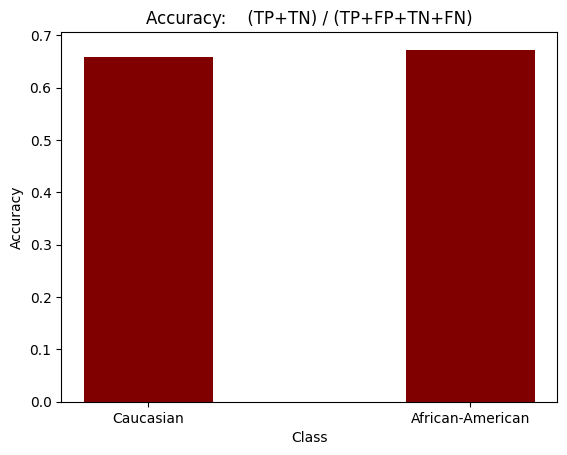

In [16]:
plt.bar(['Caucasian','African-American'], [acc_0,acc_1], color ='maroon', width = 0.4)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Accuracy:    (TP+TN) / (TP+FP+TN+FN)")
plt.show()

It appears that the algorithm is similarly "accurate" for both groups, and in fact the accuracy is even somewhat higher for the protected group.

Hence, one may conclude that the algorithm performs reasonably well---and that there are no major concerns with regards to differential performance for the protected group. In fact, this may have been the mindset by the creators of the COMPAS algorithm.

### Alternative Fairness Metrics

While "accuracy"---or one minus accuracy, which is the misclassification rate---do not point to problems, we can investigate more differentiated error metrics. One obvious way of doing this is by comparing

We can further assess the performance by visualizing false negative rates and the true positive rates by group. One way of looking at this is how many of the negatively classified individuals (low risk) were labeled so incorrectly, and how many of the positively classified (high risk) were labeled so correctly. The former proportion of negatively classified for which outcome indeed was one is also referred to as the *False Omission Rate*, whereas the latter proportion of positively classified that were indeed correct is also referred to as *Precision*:

<Axes: xlabel='Metric', ylabel='rate'>

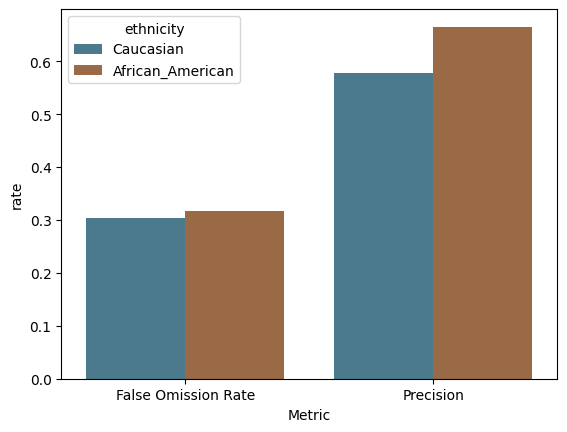

In [17]:
aq_palette = sns.diverging_palette(225, 35, n=2)
data_tmp = [['False Omission Rate',FN_0/(TN_0+FN_0),'Caucasian'],['False Omission Rate',FN_1/(TN_1+FN_1),'African_American'],['Precision',TP_0/(TP_0+FP_0),'Caucasian'],['Precision',TP_1/(TP_1+FP_1),'African_American']]
df_tmp = pd.DataFrame(data_tmp, columns=['Metric','rate','ethnicity'])
sns.barplot(df_tmp, x="Metric", y="rate", hue="ethnicity", palette=aq_palette)

We start seeing some differences between the groups, although the differences are not startling. The algorithm seems to me more “precise” for the protected class.

Differences between the groups start to emerge if we consider indviduals that are labeled as being likely to re-offend, i.e., the total fraction of positives between the two groups:

[Text(0.5, 1.0, 'proportion of group classified positive -- a measure of disparate impact')]

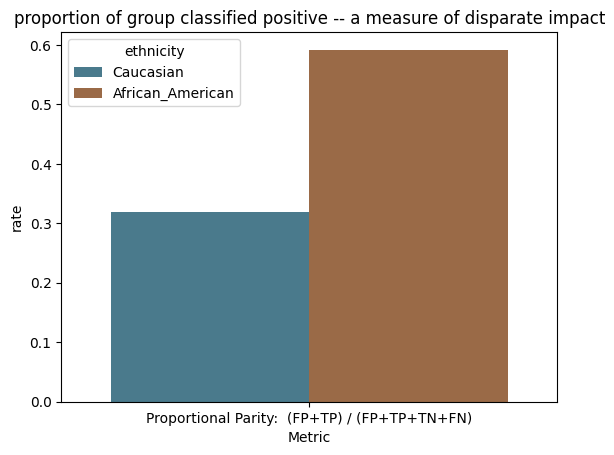

In [18]:
aq_palette = sns.diverging_palette(225, 35, n=2)
data_tmp = [['Proportional Parity:  (FP+TP) / (FP+TP+TN+FN)',(FP_0+TP_0)/(TN_0+FN_0+FP_0+TP_0),'Caucasian'],['Proportional Parity:  (FP+TP) / (FP+TP+TN+FN)',(FP_1+TP_1)/(TN_1+FN_1+FP_1+TP_1),'African_American']]
df_tmp = pd.DataFrame(data_tmp, columns=['Metric','rate','ethnicity'])
sns.barplot(df_tmp, x="Metric", y="rate", hue="ethnicity", palette=aq_palette).set(title='proportion of group classified positive -- a measure of disparate impact')

Hence, it appears that the COMPAS algorithm does have disparate impact between the two classes. Based on our comparisons from above, one may argue that this is a consequence of the statistical fact that within this population, the rate of re-offenders in the protected class was higher. Indeed, the disparate impact is associated with the accuracy of the algorithm.

In relation to the disparate impact, we can ask how the algorithm performs with regards to accurately labeling individuals. We start by investigating true positives, i.e., the proportion of positives that were classified correctly—which is also called the sensitivity. One minus the sensitivity corresponds to the positives that were incorrectly labeled, i.e., the false negative rate:

<Axes: xlabel='Metric', ylabel='rate'>

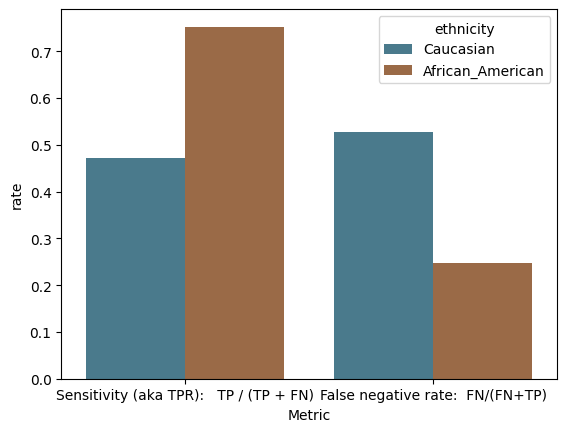

In [19]:
aq_palette = sns.diverging_palette(225, 35, n=2)
data_tmp = [['Sensitivity (aka TPR):   TP / (TP + FN)',TP_0 / (FN_0+TP_0),'Caucasian'],['Sensitivity (aka TPR):   TP / (TP + FN)',TP_1 / (FN_1+TP_1),'African_American'],['False negative rate:  FN/(FN+TP)',FN_0 / (FN_0+TP_0),'Caucasian'],['False negative rate:  FN/(FN+TP)',FN_1 / (FN_1+TP_1),'African_American']]
df_tmp = pd.DataFrame(data_tmp, columns=['Metric','rate','ethnicity'])
sns.barplot(df_tmp, x="Metric", y="rate", hue="ethnicity", palette=aq_palette)

The relationship between the sensitivity and the false negative rate is:

In [22]:
TP_0 / (FN_0+TP_0) + FN_0 / (FN_0+TP_0)

1.0

In [21]:
TP_1 / (FN_1+TP_1) + FN_1 / (FN_1+TP_1)

1.0

So it appears that the COMPAS algorithm is more "sensitive" for the protected class, and, ergo, the false negative rate is higher for the non-protected class. The latter means that the the number of high-risk individuals that were missed---and erroneously recommended for parole---is higher for the non-protected class.

Recall that *Sensitivity* is on the y-axis of the ROC curve, so we know there is a tradeoff between sensitivity and the *False Positive Rate* (FPR), which in turn is one minus *Specificity*. The FPR simply is the percent of negatives incorrecly labeled as one:

<Axes: xlabel='Metric', ylabel='rate'>

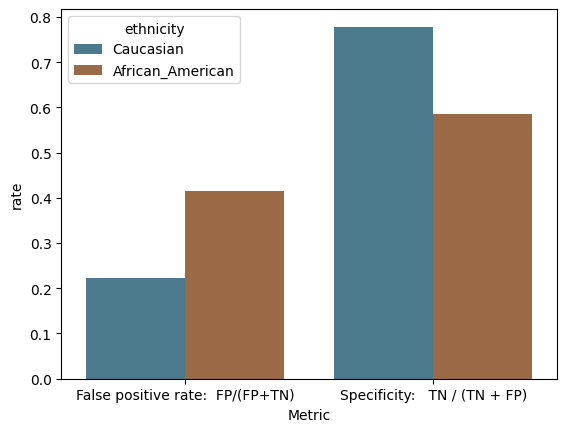

In [23]:
aq_palette = sns.diverging_palette(225, 35, n=2)
data_tmp = [['False positive rate:  FP/(FP+TN)',FP_0 / (FP_0+TN_0),'Caucasian'],['False positive rate:  FP/(FP+TN)',FP_1 / (FP_1+TN_1),'African_American'],['Specificity:   TN / (TN + FP)',TN_0 / (TN_0+FP_0),'Caucasian'],['Specificity:   TN / (TN + FP)',TN_1 / (TN_1+FP_1),'African_American']]
df_tmp = pd.DataFrame(data_tmp, columns=['Metric','rate','ethnicity'])
sns.barplot(df_tmp, x="Metric", y="rate", hue="ethnicity", palette=aq_palette)

The relationship between the specificity and the false positive rate is:

In [24]:
FP_0 / (FP_0+TN_0) + TN_0 / (TN_0+FP_0)

1.0

In [25]:
FP_1 / (FP_1+TN_1) + TN_1 / (TN_1+FP_1)

1.0

We notice that the FPR is substantially higher for the protected class, i.e., the proportion of individuals that were erroneously labeled as high risk to re-offend is substantially higher in the protected class than in the non-protected class! Being more at risk of being erroneously labeled as high-risk to re-offend based on the color of risk does seem like a problem.

### Intution: Generalized Confusion Matrix

But how is it possible that the algorithm appears similarly accurate for the two groups, yet the chance of being erroneously classified as high risk is much higher for the protected group?

To provide intuition, let's generate a generalized confusion table, where we illustrate all the correctly and erronrously classified individuals by class:


In [26]:
data_tmp = [['prot=0 event=0',TN_0,FP_0],['prot=0 event=1',FN_0,TP_0],['prot=1 event=0',TN_1,FP_1],['prot=1 event=1',FN_1,TP_1]]
df_tmp = pd.DataFrame(data_tmp, columns=[' ', 'decision=0','decision=1'])
df_tmp

,,decision=0,decision=1
0,prot=0 event=0,997,284
1,prot=0 event=1,434,388
2,prot=1 event=0,885,629
3,prot=1 event=1,411,1250


And let’s visualize:

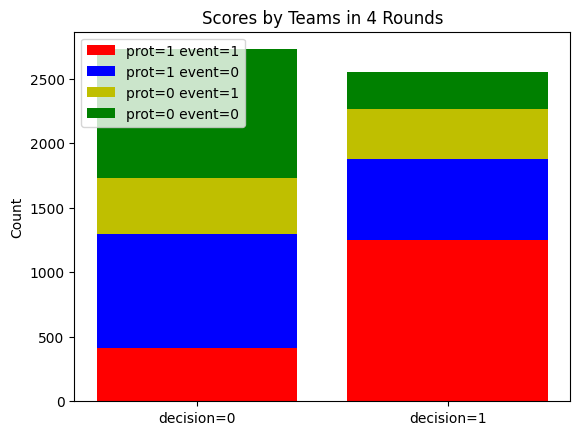

In [27]:
x = ['decision=0','decision=1']
y1 = np.array([FN_1,TP_1])
y2 = np.array([TN_1,FP_1])
y3 = np.array([FN_0,TP_0])
y4 = np.array([TN_0,FP_0])

plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.bar(x, y3, bottom=y1+y2, color='y')
plt.bar(x, y4, bottom=y1+y2+y3, color='g')
plt.ylabel("Count")
plt.legend(["prot=1 event=1", "prot=1 event=0", "prot=0 event=1", "prot=0 event=0"])
plt.title("Scores by Teams in 4 Rounds")
plt.show()

We have the labels on the horizontal, and the actual outcomes on the vertical. The large FPR is driven by the large fraction of individuals in the protected class labeled as one.

### Enforcing Fairness via Different Thresholds

As we illustrated, there are different notions of fairness one may apply. However, it seems intutive that the high FPR for the protected class may be perceived problematic. Being erroneously denied parole based on the color of one's skin arguably is perceived as unfair by many.

This intuition is in line with prescriptions from scholars that have attempted to organize different fairness metrics. For instance, the bias audit toolkit [Aequitas](http://www.datasciencepublicpolicy.org/our-work/tools-guides/aequitas/) provides a "fairness tree" that organizes different metrics. Considering this situation where interventions are "punitive" and we are worried about individuals where "intervention is not warranted" (i.e., those that won't re-offend), Aequitas' fairness tree suggests that "FPR Parity"---i.e., equating FPR rates across the different classes---is an appropriate metric.

How can we realize this? We can adjust the threshold for the protected class to above 0.5, i.e., requiring a higher score to be labeled high risk. After some experimentation, it appears 0.605 is a threshold that roughly equates false positive rates:

In [28]:
upd_afram = (dat.loc[dat['ethnicity'] == 'African_American']['probability'] > 0.605)

In [29]:
TP_0 = sum((dat.loc[dat['ethnicity'] == 'Caucasian']['Two_yr_Recidivism'] == "yes") * dat.loc[dat['ethnicity'] == 'Caucasian']['predicted'])
TP_1 = sum((dat.loc[dat['ethnicity'] == 'African_American']['Two_yr_Recidivism'] == "yes") * upd_afram)
FP_0 = sum((dat.loc[dat['ethnicity'] == 'Caucasian']['Two_yr_Recidivism'] == "no") * dat.loc[dat['ethnicity'] == 'Caucasian']['predicted'])
FP_1 = sum((dat.loc[dat['ethnicity'] == 'African_American']['Two_yr_Recidivism'] == "no") * upd_afram)
FN_0 = sum((dat.loc[dat['ethnicity'] == 'Caucasian']['Two_yr_Recidivism'] == "yes") * (dat.loc[dat['ethnicity'] == 'Caucasian']['predicted'] == 0))
FN_1 = sum((dat.loc[dat['ethnicity'] == 'African_American']['Two_yr_Recidivism'] == "yes") * (upd_afram == 0))
TN_0 = sum((dat.loc[dat['ethnicity'] == 'Caucasian']['Two_yr_Recidivism'] == "no") * (dat.loc[dat['ethnicity'] == 'Caucasian']['predicted'] == 0))
TN_1 = sum((dat.loc[dat['ethnicity'] == 'African_American']['Two_yr_Recidivism'] == "no") * (upd_afram == 0))

<Axes: xlabel='Metric', ylabel='rate'>

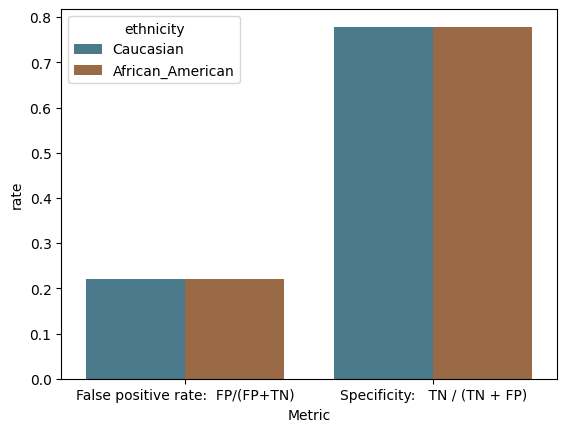

In [30]:
aq_palette = sns.diverging_palette(225, 35, n=2)
data_tmp = [['False positive rate:  FP/(FP+TN)',FP_0 / (FP_0+TN_0),'Caucasian'],['False positive rate:  FP/(FP+TN)',FP_1 / (FP_1+TN_1),'African_American'],['Specificity:   TN / (TN + FP)',TN_0 / (TN_0+FP_0),'Caucasian'],['Specificity:   TN / (TN + FP)',TN_1 / (TN_1+FP_1),'African_American']]
df_tmp = pd.DataFrame(data_tmp, columns=['Metric','rate','ethnicity'])
sns.barplot(df_tmp, x="Metric", y="rate", hue="ethnicity", palette=aq_palette)

Adjusting the threshold generally results in a less "accurate" algorithm. Let's check the accuracy level for the modified algorithm:

In [31]:
acc = (TP_0+TP_1+TN_0+TN_1)/(TP_0 + FP_0 + TP_1 + FP_1 + TN_0 + FN_0 + TN_1 + FN_1)
acc

0.656498673740053

Surprisingly, the accuracy only drops slightly from the original accuracy score of 0.667.

For the non-protected group it stays the same:

In [32]:
acc_0 = (TP_0+TN_0)/(TP_0 + FP_0 + TN_0 + FN_0)
acc_0

0.6585829766999525

But there is a decrease for the protected class:

In [33]:
acc_1 = (TP_1+TN_1)/(TP_1 + FP_1 + TN_1 + FN_1)
acc_1

0.6551181102362205

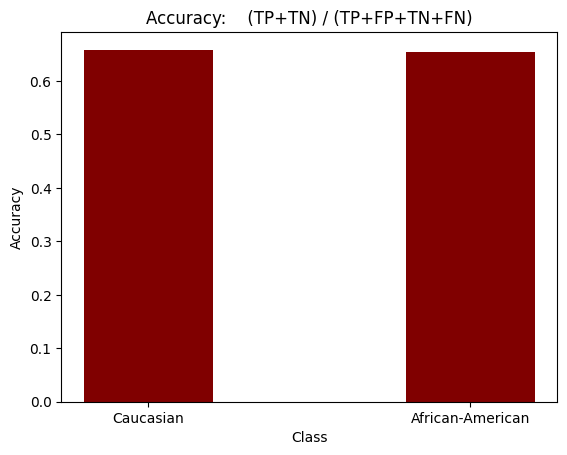

In [34]:
plt.bar(['Caucasian','African-American'], [acc_0,acc_1], color ='maroon', width = 0.4)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Accuracy:    (TP+TN) / (TP+FP+TN+FN)")
plt.show()

So we obtain a slight drop for the protected group, but this appears a small price to pay to ensure the equivalence of false positive rates and the associated fairness in this example setting.

## Using the Aequitas Library

Let's now see how to use Aequitas library to analyze the predictions for fairness. More details can be found [here](https://colab.research.google.com/github/dssg/aequitas/blob/update_compas_notebook/docs/source/examples/compas_demo.ipynb).

### Data Format

Aequitas requires a column named `score` that has the predicted label by the algorithm (should be 0 / 1) and a column named `label_value` that has the actual class. We reformat our dataset to adhere to this format, and we also drop all the non-ethnicity columns to focus on that attribute. (One needs to drop the non-string columns in any case, otherwise there is an error message.)

In [35]:
dat = dat.rename(columns={"predicted": "score", "Two_yr_Recidivism": "label_value"})
dat = dat.drop(columns=['Number_of_Priors', 'probability','Unnamed: 0','Age_Above_FourtyFive','Age_Below_TwentyFive','Female','Misdemeanor'])
dat.label_value = dat.label_value.map(dict(yes=1, no=0))
dat.head()

,label_value,ethnicity,score
1,1,Caucasian,1
2,0,Caucasian,0
3,0,African_American,0
6,1,African_American,1
7,1,African_American,1


### Using Aequitas to Obtain Confusion Values and Rates

We can now use Aequitas to obtain the count of true positives, false positives, true negatives, and false negatives by group--as well as corresponding rates.

In [36]:
g = Group()
xtab, _ = g.get_crosstabs(dat)

In [37]:
absolute_metrics = g.list_absolute_metrics(xtab)

In [38]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,2551,ethnicity,African_American,1879,1296,629,411,885,1250,1661,1514,3175,5278
1,0,binary 0/1,2551,ethnicity,Caucasian,672,1431,284,434,997,388,822,1281,2103,5278


In [39]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,ethnicity,African_American,0.75,0.58,0.32,0.33,0.42,0.25,0.68,0.67,0.74,0.59,0.52
1,ethnicity,Caucasian,0.47,0.78,0.30,0.42,0.22,0.53,0.70,0.58,0.26,0.32,0.39


### Bias Analyses

We can now obtain bias outcomes, where we have to define a reference group. Here we use the Caucasian subgroup.

In [40]:
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df=dat,
                                        ref_groups_dict={'ethnicity':'Caucasian'},
                                        alpha=0.05, check_significance=True,
                                        mask_significance=True)
bdf.style

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,2551,ethnicity,African_American,0.752559,0.584544,0.317130,0.334753,0.415456,0.247441,0.682870,0.665247,1879,1296,0.736574,0.591811,629,411,885,1250,1661,1514,3175,5278,0.523150,True,True,0.792090,Caucasian,True,0.468656,Caucasian,False,1.045651,Caucasian,False,1.873939,Caucasian,True,0.980128,Caucasian,False,2.796131,Caucasian,True,1.852051,Caucasian,True,1.152181,Caucasian,True,0.751054,Caucasian,True,1.594338,Caucasian,False
1,0,binary 0/1,2551,ethnicity,Caucasian,0.472019,0.778298,0.303284,0.422619,0.221702,0.527981,0.696716,0.577381,672,1431,0.263426,0.319544,284,434,997,388,822,1281,2103,5278,0.390870,False,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False


We can use a variety of metrics. Given the discussion above, we use false positive rate (FPR):

In [41]:
metrics = ['fpr']
disparity_tolerance = 1.25

Let's visualize:

In [42]:
ap.summary(bdf, metrics, fairness_threshold = disparity_tolerance)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [43]:
ap.disparity(bdf, metrics, 'ethnicity', fairness_threshold = disparity_tolerance)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

As we have seen above, the FPR is substantially higher for the African-American poppulation--and also for native Americans.